# Intrinsic Model of Coregionalization -- Stochastic Variational Inference


Point of this notebook is to implement a stochastic variational inference version of the ICM. This follows directly from Titsias 2009 formulation and the SVI version from Hensman 2015

## The ICM

The ICM model is a multi-output GP with a specific covariance structure. It can be constructed from a *Linear model of coregionalization (LMC)* by assuming that the j-th output $f_j(x)$ is a linear combination of $p$ latent functions $\{u_k(x)\}_{k=1}^r$ like so:

$$
f_j(x) = a_{j1} u_1(x) + a_{j2}u_2(x) + \cdots a_{jr}u_r(x), 
$$
where $\{a_{jk}\}_{k=1}^r$ are parameters to be learned. The latent functions are given independent GP priors, $u_k \sim \mathcal{GP}(0,\kappa_k(\cdot,\cdot))$, and the ICM corresponds to the special case where all the latents have the same kernel function, $\kappa_k = \kappa \ \forall k$.

Assuming we have $m$ distinct outputs, the model can be written on matrix form as 


\begin{align}
\begin{bmatrix}
f_1(x) \\
\vdots \\
f_m(x) 
\end{bmatrix} &=
\begin{bmatrix}
a_{11} & a_{12} & \cdots & a_{1r} \\
a_{21} & a_{22} & \cdots & a_{2r} \\
\vdots & \vdots & \ddots & \vdots \\
a_{m1} & a_{m2} & \cdots & a_{mr} \\
\end{bmatrix}
\begin{bmatrix}
u_1(x) \\
u_2(x) \\
\vdots \\
u_r(x) \\
\end{bmatrix}
\end{align}
or more concisely as:

\begin{align}
\mathbf{f}(x) = A \mathbf{u}(x).
\end{align}

This structure ensures that the covariance between two outputs can be written as

\begin{align}
\text{Cov}[f_i(x),f_j(x')] &= \text{Cov}\left[\sum_{k=1}^r a_{ik}u_k(x),\sum_{k=1}^r a_{jk}u_k(x)\right] \\
&= \sum_{k=1}^r a_{ik}a_{jk}\text{Cov}[u_k(x),u_k(x')] \\
&= \sum_{k=1}^r a_{ik}a_{jk}\kappa(x,x').
\end{align}

Where $\sum_{k=1}^r a_{ik}a_{jk}$ is simply the dot-product between the $i$-th and $j$-th row of the matrix $A$. Thus taking the covariance over the entire vector $\mathbf{f}(x)$ we obtain:

\begin{align}
\text{Cov}[\mathbf{f}(x),\mathbf{f}(x')] &= AA^T\kappa(x,x') \\
&= B\kappa(x,x'),
\end{align}
where the matrix $B=AA^T$ is called the *coregionalization* matrix. If furthermore each output $f_j(x)$ has been observed on the same set of inputs $X=\{x_1,\ldots,x_n\}, then the covariance can be written as 

\begin{align}
\text{Cov}[\mathbf{f}(X),\mathbf{f}(X')] &= B \otimes K_{ff},
\end{align}
where $K_{ff}=\kappa(X,X)$. This structure yields significant computational speedups for the ICM.

Finally, we usually assume our observations are noisy evaluations of the latent function, i.e. $y_{ij} = f_j(x_i) + \epsilon_{ij}$, with usually $\epsilon_{ij}\sim N(0,\sigma^2)$.


## Variational inference in the ICM

Variational inference follows the standard Titsias 2009 approach by choosing a set of inducing point locations $Z=\{z_1,\ldots,z_q\}$ and modifying the model structure by a set of inducing variables $\mathbf{u}$ usually taken as the function $f$ evaluated at each location. For multi-output GPs, considering inducing points as observations of each output $f_j$ will lead to a lower bound that is computationally quite difficult to evaluate. It is common to instead take as inducing variables the set of evaluations of the latent functions, i.e. $\mathbf{u}=\{u_k(Z)\}_{k=1}^r$. This will lead to a computationally quite cheap lower bound due to the independence assumption between each latent function. Furthermore, since all functions have the same length scale, we use the same set of inducing point locations for each latent function.

Starting from the usual model we modify it with inducing variables: $p(\mathbf{y},\mathbf{f},\mathbf{u})=p(\mathbf{y}\vert \mathbf{f})p(\mathbf{f}\vert\mathbf{u})p(\mathbf{u})$, which fundamentally doesn't change the model as if we were to integrate out the inducing variables, we would be back to the original model.

The distribution for $\mathbf{y}\vert\mathbf{f}$ and $\mathbf{u}$ are easily available, 
\begin{align}
p(\mathbf{y} \vert \mathbf{f}) &= \mathcal{N}(\mathbf{f},\sigma^2I) & \text{likelihood} \\
p(\mathbf{u}) &= \mathcal{N}(0,I\otimes K_{uu}) & \text{prior on inducing variables},
\end{align}
but the conditional prior on $\mathbf{f}\vert\mathbf{u}$ requires a little more work. Starting from the joint distribution

$$
p(\mathbf{f},\mathbf{u}) = \mathcal{N}\left(\begin{bmatrix}0\\0\end{bmatrix},\begin{bmatrix}B\otimes K_{ff} & A \otimes K_{fu} \\ A^T\otimes K_{uf} & I \otimes K_{uu}\end{bmatrix}\right),
$$
one can with a little algebra show that 
$$
p(\mathbf{f} \vert\mathbf{u}) = \mathcal{N}\left((A\otimes(K_{fu}K_{uu}^{-1})\mathbf{u},B\otimes(K_{ff}-K_{fu}K_{uu}^{-1}K_{uf}))\right).
$$

Which completes the specification of the joint model over $p(\mathbf{y},\mathbf{f},\mathbf{u})$.

We wish to learn parameters in this model by maximizing a lower bound over the marginal likelihood. Introducing the variational distribution $\phi(\mathbf{u})$ and applying Jensen's inequality we can write the log marginal likelihood as
\begin{align}
\log p(\mathbf{y}) &= \log \int p(\mathbf{y}\vert\mathbf{f})p(\mathbf{f}\vert\mathbf{u})p(\mathbf{u})\text{d}\mathbf{f}\text{d}\mathbf{u} \\
&=\log \int p(\mathbf{f}\vert\mathbf{u})\phi(\mathbf{u})\frac{p(\mathbf{y}\vert\mathbf{f})p(\mathbf{u})}{\phi(\mathbf{u})}\text{d}\mathbf{f}\text{d}\mathbf{u} \\ 
&\geq \int p(\mathbf{f}\vert\mathbf{u})\phi(\mathbf{u})\log\frac{p(\mathbf{y}\vert\mathbf{f})p(\mathbf{u})}{\phi(\mathbf{u})}\text{d}\mathbf{f}\text{d}\mathbf{u} \\
&=\int \phi(\mathbf{u})\left[\int p(\mathbf{f}\vert\mathbf{u})\log p(\mathbf{y}\vert \mathbf{f})\text{d}\mathbf{f}+\log\frac{p(\mathbf{u})}{\phi(\mathbf{u})}\right]\text{d}\mathbf{u}.
\end{align}

The interior integral wrt $\mathbf{f}$ can be written as
\begin{align}
\log G(\mathbf{u},\mathbf{y})=\int p(\mathbf{f}\vert\mathbf{u})\log p(\mathbf{y}\vert \mathbf{f})\text{d}\mathbf{f} = \log \mathcal{N}(\mathbf{y}\vert \boldsymbol{\alpha},\sigma^2I) - \frac{1}{2\sigma^2}\text{Tr}(B)\text{Tr}(K_{ff}-K_{fu}K_{uu}^{-1}K_{uf}),
\end{align}
where $\boldsymbol{\alpha}=(A\otimes (K_{fu}K_{uu}^{-1}))\mathbf{u}$.


Plugging this back into the bound and reversing Jensen's inequality we get 
\begin{align}
\log p(\mathbf{y}) &\geq \int \phi(\mathbf{u})\log \frac{\mathcal{N}(\mathbf{y}\vert \boldsymbol{\alpha},\sigma^2I)p(\mathbf{u})}{\phi(\mathbf{u})}\text{d}\mathbf{u}-\frac{1}{2\sigma^2}\text{Tr}(B)\text{Tr}(K_{ff}-K_{fu}K_{uu}^{-1}K_{uf}) \\
&\leq \log \int \mathcal{N}(\mathbf{y}\vert \boldsymbol{\alpha},\sigma^2I)p(\mathbf{u})-\frac{1}{2\sigma^2}\text{Tr}(B)\text{Tr}(K_{ff}-K_{fu}K_{uu}^{-1}K_{uf}).
\end{align}

This bound is reached when $\phi(\mathbf{u})\propto  \mathcal{N}(\mathbf{y}\vert \boldsymbol{\alpha},\sigma^2I)p(\mathbf{u})$








Inspecting $\mathcal{N}(\mathbf{y}\vert \boldsymbol{\alpha},\sigma^2I)p(\mathbf{u})$ one can with a great deal of algebra write it as:

\begin{align}
\mathcal{N}(\mathbf{y}\vert \boldsymbol{\alpha},\sigma^2I)p(\mathbf{u})=
\mathcal{N}(\mathbf{u}\vert C^{-1}d,C^{-1})\mathcal{N}(\mathbf{y}\vert 0,B\otimes K_{fu}K_{uu}^{-1}K_{uf}+\sigma^2I),
\end{align}
where $C=I\otimes K_{uu}^{-1}+\sigma^{-2}(A^T\otimes K_{uu}^{-1}K_{uf}(A\otimes K_{fu}K_{uu}^{-1}))$, and $d=\sigma^{-2}(A^T\otimes K_{uu}^{-1}K_{uf})\mathbf{y}$.

Integrating over $\mathbf{u}$ in the bound yields now:

\begin{align}
\log p(\mathbf{y}) \geq \mathcal{N}(\mathbf{y}\vert 0,B\otimes K_{fu}K_{uu}^{-1}K_{uf}+\sigma^2I) -\frac{1}{2\sigma^2}\text{Tr}(B)\text{Tr}(K_{ff}-K_{fu}K_{uu}^{-1}K_{uf})
\end{align}

Computing the bound itself requires the following quantities

\begin{gather}
\text{(Quadratic form)} & \mathbf{y}^T\left[(B\otimes K_{fu}K_{uu}^{-1}K_{uf})+\sigma^2I\right]^{-1}\mathbf{y} = \mathbf{y}^T\left[\sigma^{-2}I-\sigma^{-2}D^T(I+DD^T)^{-1}D\right]\mathbf{y} \\
\text{(Determinant)} & \vert (B\otimes K_{fu}K_{uu}^{-1}K_{uf})+\sigma^2I \vert = \vert I + DD^T) \vert \vert \sigma^2I \vert ,
\end{gather}

where $D=A^T\otimes L^{-1}K_{uf}\sigma^{-1}$, $DD^T=A^TA \otimes L^{-1}K_{uf}K_{fu}L^{-T}\sigma^{-2}$ and $L$ from $K_{uu}=LL^T$. Both of these can be done via the eigendecomposition of $DD^T$.

Note that the complexity here isn't terrible. We need to get hold of and invert L (which is $q \times q$) and we need to eigendecomp $DD^T$ but this is on the form of a Kronecker product so we simply eigen-decomp $A^TA$ and $L^{-1}K_{uf}K_{fu}L^{-T}\sigma^{-2}$ which are $r \times r$ and $q \times q$ respectively. 

Predicting for some new input now is also straight forward and has nice formulas.

However, while this would all probably work out well, it does rely on having every observed every input on every output. And while it might be possible to get around this now by the same techniques we used for PIICM, it's hard to tell what we are really gaining then.

Instead we should pursue **Stochastic Variational inference (SVI)**, following Hensman 2015 -- which is also **the** way `gpytorch` implements basic variational inference for GPs. (The Titsias bound of using the optimal variational distribution is still available, but via a bit of a hack with adding loss in the marginal likelihood calculation.)

## Stochastic Variational inference for the ICM

Instead of finding the optimal variational distribution $\phi^*(\mathbf{u})$ and margincalising them out, stochastic variational inference instead explicitly keeps them in the model as global parameters. We start in the same way by modifying the original model by $p(\mathbf{y},\mathbf{f},\mathbf{u})=p(\mathbf{y}\vert\mathbf{f})p(\mathbf{f}\vert\mathbf{u})p(\mathbf{u})$, then we introduce a variational distribution $\phi(\mathbf{u})=\mathcal{N}(\mathbf{m},S)$ and bound the marginal likelihood

\begin{align}
\log p(\mathbf{y}) &= \log \int p(\mathbf{y}\vert\mathbf{f})p(\mathbf{f}\vert\mathbf{u})p(\mathbf{u})\text{d}\mathbf{f}\text{d}\mathbf{u} \\
&=\log \int p(\mathbf{f}\vert\mathbf{u})\phi(\mathbf{u})\frac{p(\mathbf{y}\vert\mathbf{f})p(\mathbf{u})}{\phi(\mathbf{u})}\text{d}\mathbf{f}\text{d}\mathbf{u} \\ 
&\geq \int p(\mathbf{f}\vert\mathbf{u})\phi(\mathbf{u})\log\frac{p(\mathbf{y}\vert\mathbf{f})p(\mathbf{u})}{\phi(\mathbf{u})}\text{d}\mathbf{f}\text{d}\mathbf{u} \\
&=\int \phi(\mathbf{u})\left[\int p(\mathbf{f}\vert\mathbf{u})\log p(\mathbf{y}\vert \mathbf{f})\text{d}\mathbf{f}+\log\frac{p(\mathbf{u})}{\phi(\mathbf{u})}\right]\text{d}\mathbf{u} \\
&= \int \phi(\mathbf{u})\log \frac{\mathcal{N}(\mathbf{y}\vert \boldsymbol{\alpha},\sigma^2I)p(\mathbf{u})}{\phi(\mathbf{u})}\text{d}\mathbf{u}-\frac{1}{2\sigma^2}\text{Tr}(B)\text{Tr}(K_{ff}-K_{fu}K_{uu}^{-1}K_{uf}) \\
&= \int \phi(\mathbf{u})\log \mathcal{N}(\mathbf{y}\vert \boldsymbol{\alpha},\sigma^2I)\text{d}\mathbf{u}+ \int \phi(\mathbf{u})\log\frac{p(\mathbf{u})}{\phi(\mathbf{u})}\text{d}\mathbf{u}-\frac{1}{2\sigma^2}\text{Tr}(B)\text{Tr}(K_{ff}-K_{fu}K_{uu}^{-1}K_{uf}) \\
&= \int \phi(\mathbf{u})\log \mathcal{N}(\mathbf{y}\vert \boldsymbol{\alpha},\sigma^2I)\text{d}\mathbf{u}- \text{KL}(\phi(\mathbf{u}) \Vert p(\mathbf{u}))-\frac{1}{2\sigma^2}\text{Tr}(B)\text{Tr}(K_{ff}-K_{fu}K_{uu}^{-1}K_{uf})
\end{align}
where again $\boldsymbol{\alpha}=(A\otimes (K_{fu}K_{uu}^{-1}))\mathbf{u}$.

<font color='red'>I need to look at $\int p(\mathbf{f}\vert\mathbf{u})\log p(\mathbf{y}\vert \mathbf{f})\text{d}\mathbf{f}$ again. Particularly the case where I don't have every observed $y_{ij}$ at every $f_{ij}$! It might just be ignoring the diagonal terms of the trace in this case, all else equal. </font> 

<font color='green'>Yes, it simply amounts to ignoring diagonal terms where we don't have observations. For this reason, the trace term needs to go inside the summation over the observations, $y_i$. We can further index this by outputs and sum first over the $m$ outputs, and then over $n$ observations within each output. Furthermore, we can make $n$ depend on the number of observations in that specific output. </font> 

Now, this bound is seperable in the observations $y_{ij}$ and we can write

\begin{align}
&\int \phi(\mathbf{u})\log \mathcal{N}(\mathbf{y}\vert \boldsymbol{\alpha},\sigma^2I)\text{d}\mathbf{u} \\
=& \sum_{j=1}^m\sum_{i=1}^n \log \mathcal{N}(y_{ij}\vert \tilde{\boldsymbol{\alpha}}_{ij}\mathbf{m}, \sigma^2) - \frac{1}{2\sigma^2}\tilde{\boldsymbol{\alpha}}_{ij}S\tilde{\boldsymbol{\alpha}}_{ij}^T,
\end{align}
where $\tilde{\boldsymbol{\alpha}}_{ij}=(A_{j\cdot}\otimes K_{fu,i\cdot}K_{uu}^{-1})$, $A_{j\cdot}$ denotes the $j$-th row of $A$ and $K_{fu,i\cdot}$ the $i$-th row of $K_{fu}$.

Putting this all together now, the bound becomes:

\begin{align}
\log p(\mathbf{y}) \geq \sum_{j=1}^m\sum_{i=1}^n \left\{ \log \mathcal{N}(y_{ij}\vert \tilde{\boldsymbol{\alpha}}_{ij}\mathbf{m}, \sigma^2) - \frac{1}{2\sigma^2}\tilde{\boldsymbol{\alpha}}_{ij}S\tilde{\boldsymbol{\alpha}}_{ij}^T - \frac{1}{2\sigma^2}B_{jj}[K_{ff}-K_{fu}K_{uu}^{-1}K_{uf}]_{ii}\right\}- \text{KL}(\phi(\mathbf{u}) \Vert p(\mathbf{u})).
\end{align}

Finally, we can make some speedups as well regarding $\phi(\mathbf{u})$ and assume e.g. independence between latent functions, i.e. $\phi(\mathbf{u})=\prod_{k=1}^r\phi_k(\mathbf{u}_k)$, where each $\phi_k(\mathbf{u}_k)=\mathcal{N}(\mathbf{u}_k\vert \mathbf{m_K},S_K)$


## Modifying the coregionalization matrix


The structure of the coregionalization matrix as a general PSD matrix $AA^T$ invites placing e.g. a kernel function directly over the outputs. But training the variational models need an explicit representation of the matrix A, the entries of which is usually learned during training. One way to combine these two things is to use the eigen decomposition of the output kernel as parameters in the matrix A.

Specifically, let $K_O$ denote the $m\times m$ covariance matrix corresponding to some kernel function over the outputs. Then, taking the eigen decomposition one can write $K_O = UDU^T=(UD^{1/2})(UD^{1/2})^T$ where $U$ is an $m\times m$ orthonormal matrix of eigenvectors, and $D$ a $m \times m$ diagonal matrix of eigenvalues. Setting $A=(UD^{1/2})$ yields the desired structure, and parameters $a_{ij}$ can be learned as functions of the kernel hyperparameters by differentiating through the eigen decomposition.

This requires $m$ latent functions, but a low-rank version with $r<m$ latent functions can easily be constructed by truncating the eigen decomposition. 

For prediction purposes, when we wish to predict at a new output, we do the usual thing of calculating the cross-covariance $k_*$ with entries $k(t_*,t_i)$ for $i=1,\ldots,m$, where $t_i$ are covariates over the outputs. Then we find the projection of $k_*$ onto the columns of $A$, $a_* \equiv\text{proj}_A(b)=(A^TA)^{-1}A^Tk_*$, and $a_*$ is used as LMC parameters for this output. Essentially it is the point in the space spanned by $A$ closest to $k_*$.


## Implementation

The natural starting place for implementing this model is the variational LMC-implementation already in place in `gpytorch`. By simply demaning that each latent function has the same length scale, we will have an ICM model in place. Furthermore, we should look at modifying the parameters $A$ so that we can define them implicitly via the eigen-decomposition from a covariance function over the outputs. Should also note that possibly, the current implementation of the LMC is not the most optimal when using it as an ICM -- it might be doing more matrix inverses than strictly necessary for example.

### Simulate some data

Before moving on to an implementation, it makes sense to try and simulate some data first.

In [ ]:
# Some imports
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import gpytorch
import numpy as np

In [ ]:
r = 10 # Number of latents
n = 2000 # Number of observations per output
# Easiest way to sample from a GP using gpytorch?
x = torch.linspace(0,1,n)
u = torch.zeros(x.size(dim=0),r)


mean = gpytorch.means.ZeroMean()
kernel = gpytorch.kernels.RBFKernel()
kernel.lengthscale = 0.2
m = mean(x)
K = kernel(x)
for i in range(r):
    GP = gpytorch.distributions.MultivariateNormal(m,K)
    u[:,i] = GP.rsample().detach()

In [ ]:
plt.plot(x,u[:,0])
plt.plot(x,u[:,1])
plt.plot(x,u[:,2])
plt.plot(x,u[:,3])

In [ ]:
# Now creating outputs as linear combinations of these latent functions
m = 50 # num_outputs
A = torch.randn(m,r)
f = A.matmul(u.t()).t()
for i in range(m):
    plt.plot(x,f[:,i])

In [ ]:
# Now generate some corresponding data
sigma = 0.5
y = f + sigma*torch.randn(f.size())

In [ ]:
for i in range(m):
    plt.plot(x,y[:,i],".")

In [ ]:
# Now going to get it ready for minibatching
from torch.utils.data import TensorDataset, DataLoader

# Get everything into long format
y_long = y.t().reshape(-1)
x_long = x.repeat(m)
task_indices = torch.arange(0,m).unsqueeze(1).repeat(1,n).reshape(-1).long()

# For first task, will remove some central observations 
#y_long[1000:2000] = float('nan')
#x_long = x_long[~y_long.isnan()]
#task_indices = task_indices[~y_long.isnan()]
#y_long = y_long[~y_long.isnan()]

train_dataset = TensorDataset(x_long, y_long,task_indices)
train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)

# We also make a version for test here
test_x = torch.linspace(0, 1, 51).repeat(m)
test_indices = torch.arange(0,m).unsqueeze(1).repeat(1,51).reshape(-1).long()

So now we have generated data from $m=10$ outputs $f_{ij}$ at $n=100$ inputs using $r=4$ latent functions. Time to set up the LMC 

In [ ]:
class LMC(gpytorch.models.ApproximateGP):
    def __init__(self):
        # Different set of inducing points for each latent function
        inducing_points = torch.rand(r,30,1)
        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each latent
        # note that this doesn't assume the same inducing locations for each latent
        # which would speedup the ICM, but isn't technically needed.
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([r])
        )
        
        # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=m,
            num_latents=r,
            latent_dim=-1
        )
        
        super().__init__(variational_strategy)
        
        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        # For the ICM model, we do not set them as batch.
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()
        
    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    
    

model = LMC()
#likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=m)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

And training the LMC

In [ ]:
# this is for running the notebook in our testing framework
import os
import tqdm.notebook
num_epochs = 4


model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Uncomment to keep the LMC coefficients fixed at true values
#model.variational_strategy.lmc_coefficients = torch.nn.Parameter(A.t())
#optimizer = torch.optim.Adam([
#    {'params': list(set(model.parameters()) - {model.variational_strategy.lmc_coefficients, })},
#    {'params': likelihood.parameters()},
#], lr=0.01)


# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
#mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y.size(0))
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_long.size(0))

# We use more CG iterations here because the preconditioner introduced in the NeurIPS paper seems to be less
# effective for VI.
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch, task_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch,task_indices=task_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()
        
    #optimizer.zero_grad()
    #output = model(x)
    #loss = -mll(output, y)
    #epochs_iter.set_postfix(loss=loss.item())
    #loss.backward()
    #optimizer.step()

Finally predicting on some new inputs `test_x`

In [ ]:
model(test_x)

In [ ]:
# Set into eval mode
model.eval()
likelihood.eval()
# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x,task_indices=test_indices))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

We can then plot some of these tasks to inspect the model fit

In [ ]:
mean[0:51].shape

In [ ]:
task = 40
plt.plot(x,y[:,task],'k.',alpha=0.1)
plt.plot(test_x[task*51:task*51+51],mean[task*51:task*51+51],"b")
plt.plot(x,f[:,task],"r")
plt.fill_between(test_x[task*51:task*51+51], lower[task*51:task*51+51], upper[task*51:task*51+51], alpha=1)

What about parameters, to we recover the correct parameters?

In [ ]:
print(model.covar_module.lengthscale) # Rememeber true length scale is 0.2

In [ ]:
print(model.variational_strategy.lmc_coefficients.detach())
print(A.t())

It does not appear like we are estimating the correct A matrix. Could this be because the representation is a little bit different inside `LMCVariationalStrategy`? Surely it must be. Setting the number of latent functions to 1, `r=1`, we still do not find the correct parameters. They don't even have the correct sign!

No! The reason is because of an inherent identifiability issue. If we are free-form learning the latent functions $u_k(x)$ as well as the matrix $A$ there is no guarantee we converge to the same function values. In a sense the matrix $A$ is too free. This can be checked by initializing $\hat{A}=A$ and not optimizing over these parameters.

In [ ]:
latent = model.variational_strategy.base_variational_strategy(test_x.unsqueeze(-1))

In [ ]:
plt.plot(test_x,latent.mean[0,:].detach(),"b--")
plt.plot(x,u[:,0],"b")
plt.plot(test_x,latent.mean[1,:].detach(),"r--")
plt.plot(x,u[:,1],"r")

In [ ]:
model.variational_strategy.variational_distribution.covariance_matrix.shape

## Modifying the variational strategy

Okay, so the above code works well, and implements an ICM model with SVI and minibatching. The generic `GaussianLikelihood` means that we can easily incorporate observation specific noise like we have in the real synergy data -- or even *task specific* noises etc.

We need to make two more changes to get a new version of PIICM up and running:

    1. Instead of learning the matrix A "free-form", we want to learn it via a kernel over the outputs.
        i. A will be calculated from the (truncated) eigen decomposition of this kernel
        ii. We can experiment with the kernel used (i.e. MKL perhaps for the milestone)
    2. Each latent function u(x) should be permutation invariant
    
I will tackle 1. first, as I think it might be the easiest option to go for.

Looking at the original code, for the `LMCVariationalStrategy`, the LMC parameters are initialized in the `__init__` by 

```{python}
# LCM coefficients
lmc_coefficients = torch.randn(*batch_shape, self.num_tasks)
self.register_parameter("lmc_coefficients", torch.nn.Parameter(lmc_coefficients))
```

I think in principle, I just need to modify this to initialize from the eigendecomposition of the kernel.

The easiest would probably be to have the option to pass a covariance over the outputs via the initialization. When setting up the model one could do something like:

```{python}
output_kernel = RBF(whatever)

variational_strategy = gpytorch.variational.ModifiedLMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            output_kernel,
            output_covars
            num_tasks=m,
            num_latents=r,
            latent_dim=-1
        )
```
and then inside variational strategy:

```
def __init__( ...
    
    # LCM coefficients
    self.output_kernel = output_kernel
    self.output_covars = output_covars
    ...
    
@property
def lmc_coefficients(self) -> Tensor:
        evals, evecs = self.output_kernel(self.output_covars).symeig(eigenvectors=True)
        evecs = evecs[:, -self.num_latents:]
        evals = linear_operator.operators.DiagLinearOperator(evals[-self.num_latents:])
        return evecs.matmul(evals.sqrt()).t().evaluate()
```

This seems to work. I still need to work on predicting at new outputs though. I should first convince myself that the projection onto the truncated eigenbasis is the correct thing to do.

<font color='green'> Okay, I think I'm sufficiently convinced. I'll add this in the `ModifiedLMCVariationalStrategy.call()`, and hope it is not too hacky for it to extend to downstream applications such as BO. </font> 

Perhaps the easiest way to do this within the call is to check if output_covars are passed as an argument, and then set up the corresponding LMC coefficients like normally.

<font color='green'> Yeah, this is also solved now. </font>

I've modified the `__call__` of the `ModifiedLMCVariationalStrategy` with an optional additional argument, `task_covars: Optional[Tensor] = None`, that allows me to pass additional task covarites to predict at new outputs. The corresponding LMC-coefficients are generated by the aforementioned projection onto the columns of $A$, and we simply reshape them as before to multiply with the covariance coming from the latent GPs:

```
            if task_covars is None:
                lmc_coefficients = self.lmc_coefficients.expand(*latent_dist.batch_shape,
                                                                self.lmc_coefficients.size(-1))
            else:
                k_star = self.output_kernel(task_covars,self.output_covars)
                anew = torch.linalg.solve(self.lmc_coefficients.matmul(self.lmc_coefficients.t()), self.lmc_coefficients.matmul(k_star.evaluate().unsqueeze(-1))).squeeze(-1).t()
                lmc_coefficients = anew.expand(*latent_dist.batch_shape, anew.size(-1))
```

<font color='red'> Now we have a standard ICM model up and running, with a covariance function over the outputs, and using Stochastic Variational inference for the fitting. We need to make each latent function invariant at this point.</font>


<font color='green'> Not done yet! I think this might be more about modifying the kernel function for each underlying latent, and can be done efficiently in a nother notebook. Addiationally, a whole new set of plotting functions are needed to see if predictions work, so will do this later.</font>


<font color='red'> Regarding the "LMC_ness" of the model, if I have `r` latent functions mapped to `m` outputs, my A matrix will look like a `r x m` matrix. When computing the covariance matrix (in the "all-outputs" case) the LMCStrategy creates `RootLinearOperator` of each row of the A matrix, i.e. a set of `r` RootLinearOperators, each constructed by $K_i^A=A_{i\cdot}A_{i\cdot}^T$, where $A_{i\cdot}$ denotes the $i$-th row of A. Then it forms the covariance by taking the Kronecker product of $K_i$ and the latent_covariance from the latent functions $K_i^X$ and sums them $K=\sum_{i=1}^r K_i^X \otimes K_i^A$ Now, this is fine, but in a real LMC we would want to group things together that have the same length-scale but keep things separate if not. I think this can be achieved by simply using a block-diagonal A matrix with Q blocks corresponding to the number of different length scales. I also think there is probably some nuance in setting up an LMC with the correct covariance structure, and then approximating it using variational inference. I need to think about this.</font>

<font color='red'> Okay, I've given it some thought. The LMC model is sort of *de-facto* defined by it's covariance structure as a sum of Kronecker-product type things (in the completely observed case). With SVI, we don't have this exactly, because each latent GP has its own distribution over its own inducing points. But this can be explained with it being approximately true, and true when we have enough data. Because then the SVI bound will be almost exactly equal to the Titsias bound, and the "free-form" parameters $\mu_i, S_i$ will be approximately close to the ones given by Titsias.  **Also, this is about prediction, so we don't really care too much** </font>


<font color='Green'> So what needs to be done to extend this to an approximate LCM is to have A on a block-diagonal form, with $R$ blocks, each block $A_i$ an $r \times r$ block coming from the truncated eigen-decomp of a kernel over covariates. Furthermore, I need a way to pass a list of $R$ covariances so that all the $r$ latent functions within the same block gets the same covariance function.</font>

I've wrapped this up into `ModifiedLMCVariationalStrategy` as a member of `synpred.variational.modified_lmc_variational_strategy`. Will try it below

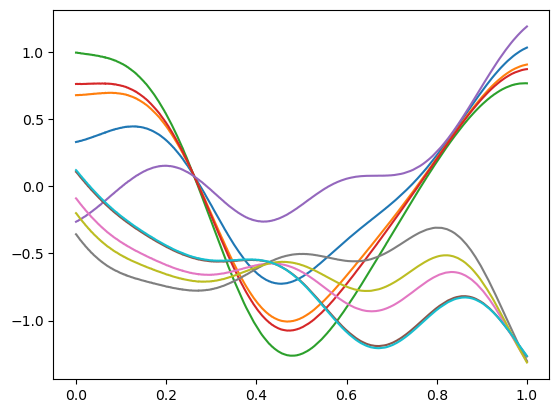

In [1]:
# Code starts as before, with some imports and generating data
# Some imports
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import gpytorch
import numpy as np
import linear_operator
r = 4 # Number of latents
n = 1000 # Number of observations per output
# Easiest way to sample from a GP using gpytorch?
x = torch.linspace(0,1,n)
u = torch.zeros(x.size(dim=0),r)


mean = gpytorch.means.ZeroMean()
kernel = gpytorch.kernels.RBFKernel()
kernel.lengthscale = 0.2
m = mean(x)
K = kernel(x)
for i in range(r):
    GP = gpytorch.distributions.MultivariateNormal(m,K)
    u[:,i] = GP.rsample().detach()
    
# Now creating outputs as linear combinations of these latent functions
# but now the lmc-parameters A is coming from another kernel over some covariates

m = 10 # num_outputs
#covar_outputs = torch.cat([1+0.1*torch.randn(int(m/2.)),-1+0.8*torch.randn(int(m/2.))])
covar_outputs = torch.cat([1+0.1*torch.randn(int(m/2.)),-1+0.1*torch.randn(int(m/2.))])
# These are just some really dumb covariates which will give some clustering structure
covar_kernel = gpytorch.kernels.RBFKernel()
covar_kernel.lengthscale = 0.4
covar_kernel = covar_kernel(covar_outputs)
evals, evecs = covar_kernel.symeig(eigenvectors=True)
evecs = evecs[:, -r:]
evals = linear_operator.operators.DiagLinearOperator(evals[-r:])
A = evecs.matmul(evals.sqrt()).evaluate().detach()

f = A.matmul(u.t()).t()
for i in range(m):
    plt.plot(x,f[:,i])
    
# Now generate some corresponding data
sigma = 0.1
y = f + sigma*torch.randn(f.size())

# Now going to get it ready for minibatching
from torch.utils.data import TensorDataset, DataLoader

# Get everything into long format
y_long = y.t().reshape(-1)
x_long = x.repeat(m)
task_indices = torch.arange(0,m).unsqueeze(1).repeat(1,n).reshape(-1).long()

# For last task, will remove some central observations 
#y_long[-5000:] = float('nan')
#x_long = x_long[~y_long.isnan()]
#task_indices = task_indices[~y_long.isnan()]
#y_long = y_long[~y_long.isnan()]

train_dataset = TensorDataset(x_long, y_long,task_indices)
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)

# We also make a version for test here
test_x = torch.linspace(0, 1, 51).repeat(m)
test_indices = torch.arange(0,m).unsqueeze(1).repeat(1,51).reshape(-1).long()

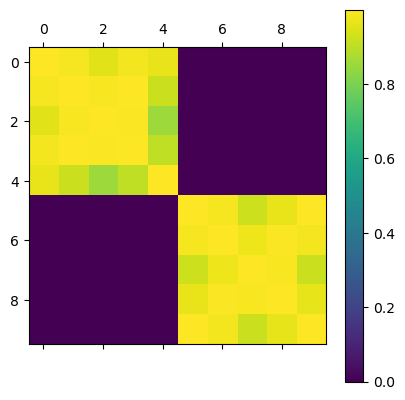

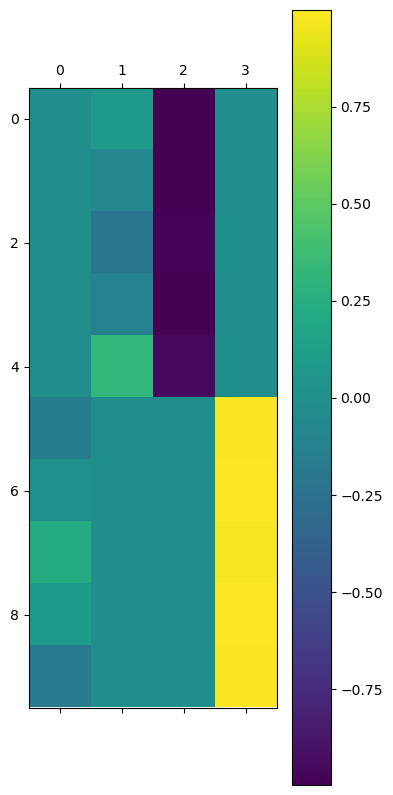

In [2]:
plt.matshow(A.matmul(A.t()))
plt.colorbar()
plt.matshow(A)
plt.colorbar()

In [7]:
from synpred.variational.modified_lmc_variational_strategy import ModifiedLMCVariationalStrategy

class ModifiedLMC(gpytorch.models.ApproximateGP):
    def __init__(self,output_covars):
        print("Init is run!")
        # Different set of inducing points for each latent function
        inducing_points = torch.rand(r,30,1)
        # Same set of inducing points for each latent function
        #inducing_points = torch.linspace(0,1,30).unsqueeze(-1).repeat(r,1,1)
        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each latent
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([r])
        )
        #variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(
        #    inducing_points.size(-2), batch_shape=torch.Size([r])
        #)
        
        # Covariance over the outputs, and initialized by covariates
        output_kernel = gpytorch.kernels.RBFKernel()
        
        # We have to wrap the VariationalStrategy in a ModifiedLMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = ModifiedLMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            output_kernel,
            output_covars,
            num_tasks=m,
            num_latents=r,
            latent_dim=-1
        )
        
        super(ModifiedLMC,self).__init__(variational_strategy)
        
        # The mean and covariance modules could be marked as batch
        # so we learn a different set of hyperparameters
        # For the ICM model, we do not set them as batch as we want the same kernel for each latent
        self.mean_module = gpytorch.means.ZeroMean()
        self.covarRRR_module = gpytorch.kernels.RBFKernel()
        
    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covarRRR_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    
    

model = ModifiedLMC(covar_outputs)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

Init is run!


In [8]:
model.covar_module

AttributeError: 'ModifiedLMC' object has no attribute 'covar_module'

In [5]:
# this is for running the notebook in our testing framework
import os
import tqdm.notebook
num_epochs = 20 # Number of complete passes through the data


model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Uncomment to keep the LMC coefficients fixed at true values
#model.variational_strategy.lmc_coefficients = torch.nn.Parameter(A.t())
#optimizer = torch.optim.Adam([
#    {'params': list(set(model.parameters()) - {model.variational_strategy.lmc_coefficients, })},
#    {'params': likelihood.parameters()},
#], lr=0.01)


# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
#mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y.size(0))
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_long.size(0))

# We use more CG iterations here because the preconditioner introduced in the NeurIPS paper seems to be less
# effective for VI.
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch, task_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch,task_indices=task_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()
        
    #optimizer.zero_grad()
    #output = model(x)
    #loss = -mll(output, y)
    #epochs_iter.set_postfix(loss=loss.item())
    #loss.backward()
    #optimizer.step()

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/50 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/50 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/50 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/50 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/50 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/50 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/50 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/50 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/50 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/50 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/50 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/50 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/50 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/50 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/50 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/50 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/50 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/50 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/50 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/50 [00:00<?, ?it/s]

In [216]:
covar_outputs

tensor([ 0.9713,  0.9762,  1.0571,  1.1456,  0.9389, -0.9218, -1.0161, -1.0903,
        -0.9623, -0.8619])

In [226]:
#newoutput = torch.tensor([0.9971,0])
newoutput = torch.linspace(-1,1,10)

test_x = torch.linspace(0, 1, 51).repeat(newoutput.size(-1))
test_indices = torch.arange(0,newoutput.size(-1)).unsqueeze(1).repeat(1,51).reshape(-1).long()

In [227]:
# Set into eval mode
model.eval()
likelihood.eval()
# Make predictions

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(test_x,task_indices=test_indices,task_covars=newoutput))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

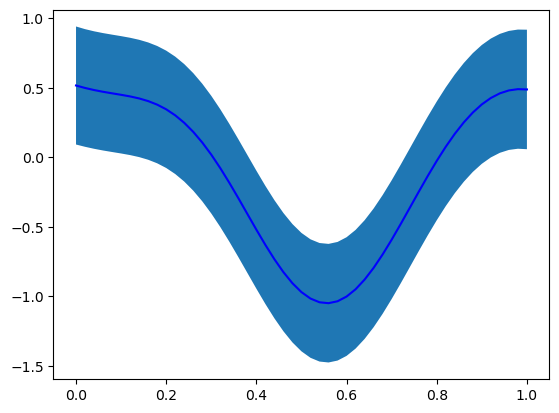

In [237]:
task = 0
plt.plot(test_x[task*51:task*51+51],mean[task*51:task*51+51],"b")
plt.fill_between(test_x[task*51:task*51+51], lower[task*51:task*51+51], upper[task*51:task*51+51])

In [84]:
mean.shape

torch.Size([510])

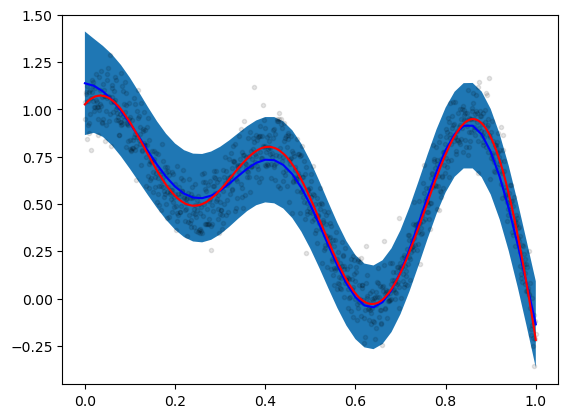

In [85]:
task = 0
plt.plot(x,y[:,task],'k.',alpha=0.1)
plt.plot(test_x[task*51:task*51+51],mean[task*51:task*51+51],"b")
plt.plot(x,f[:,task],"r")
plt.fill_between(test_x[task*51:task*51+51], lower[task*51:task*51+51], upper[task*51:task*51+51], alpha=1)

In [96]:
lower.shape

torch.Size([51, 1])

In [106]:
test_x

tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
        0.1800, 0.2000, 0.2200, 0.2400, 0.2600, 0.2800, 0.3000, 0.3200, 0.3400,
        0.3600, 0.3800, 0.4000, 0.4200, 0.4400, 0.4600, 0.4800, 0.5000, 0.5200,
        0.5400, 0.5600, 0.5800, 0.6000, 0.6200, 0.6400, 0.6600, 0.6800, 0.7000,
        0.7200, 0.7400, 0.7600, 0.7800, 0.8000, 0.8200, 0.8400, 0.8600, 0.8800,
        0.9000, 0.9200, 0.9400, 0.9600, 0.9800, 1.0000])

In [11]:
model.variational_strategy.output_kernel.lengthscale.detach().numpy()

array([[0.39530256]], dtype=float32)

In [12]:
model.variational_strategy.base_variational_strategy.inducing_points


Parameter containing:
tensor([[[ 1.2601],
         [ 0.8118],
         [ 0.9288],
         [ 0.9005],
         [ 0.1906],
         [ 0.0295],
         [ 0.1371],
         [ 0.7617],
         [ 0.4753],
         [ 0.6249],
         [ 0.5603],
         [ 0.6488],
         [ 0.4696],
         [ 1.0945],
         [ 0.7138],
         [ 1.0122],
         [ 1.2405],
         [ 0.6848],
         [ 0.6863],
         [ 0.6368],
         [ 0.3039],
         [ 0.6752],
         [ 0.9987],
         [ 0.6763],
         [ 0.6865],
         [ 0.9914],
         [ 0.3554],
         [ 0.3905],
         [ 0.5299],
         [ 0.9758]],

        [[ 0.9300],
         [ 1.1019],
         [ 1.0010],
         [-0.2489],
         [ 0.8963],
         [-0.0540],
         [ 0.9272],
         [ 0.0441],
         [ 0.8462],
         [ 0.2732],
         [ 0.8077],
         [ 0.8767],
         [ 0.7720],
         [-0.1152],
         [ 0.9452],
         [ 0.9163],
         [ 0.9255],
         [ 0.9306],
         [ 0.345

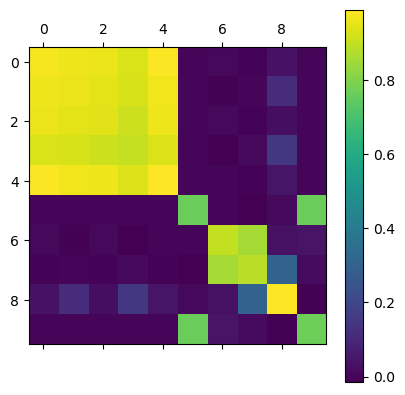

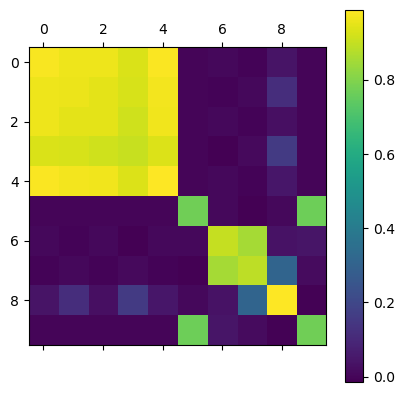

In [13]:
plt.matshow(model.variational_strategy.lmc_coefficients.t().matmul(model.variational_strategy.lmc_coefficients).detach())

plt.colorbar()
plt.matshow(A.matmul(A.t()))
plt.colorbar()

In [14]:
model.variational_strategy.base_variational_strategy.variational_distribution.mean

Parameter containing:
tensor([[ 1.3418,  0.2308,  1.0337, -0.7314,  0.4954, -0.6027, -0.7738,  1.0208,
          0.7214,  0.7826, -1.1155,  0.9980,  0.2741,  1.6129,  0.9789,  0.8944,
          0.9715,  0.6719,  0.4576,  0.0378,  0.5028,  0.3222,  0.7263,  0.2079,
          0.1576,  0.3256,  0.7637,  0.5266, -0.2676,  0.2251],
        [ 0.7111,  0.3298,  0.7695,  0.5954, -1.0278, -1.2680,  0.6101, -1.7252,
         -0.5907,  0.5707, -1.4061,  1.1803, -1.1738, -0.3153,  0.8752, -0.6910,
          0.6612,  0.7144, -0.7164, -1.5520, -1.7921, -1.8034, -1.9531, -1.1536,
         -1.7324, -1.9219, -1.0731, -1.5880,  0.1190, -0.3271],
        [ 0.3905,  0.1206,  0.7008, -0.2019,  0.8849,  1.3500,  1.2440, -1.7487,
          0.2517,  1.0496,  0.7954,  0.6906,  0.7654,  0.5577,  0.6840,  0.1173,
          0.3275,  0.4735,  0.6507,  0.7702,  0.3700,  0.6436,  0.5311,  0.5405,
          0.7622,  0.4488, -0.4946,  0.4652,  0.3935,  0.2961],
        [ 0.8572, -0.6975, -0.3803, -0.1216,  0.7086,  0.

In [15]:
model.variational_strategy.lmc_coefficients.shape

torch.Size([4, 10])

In [16]:
x_batch.unsqueeze(-1)

tensor([[0.3473],
        [0.2462],
        [0.6496],
        [0.9119],
        [0.8909],
        [0.3714],
        [0.5455],
        [0.9189],
        [0.6216],
        [0.3233],
        [0.5596],
        [0.8639],
        [0.7417],
        [0.7658],
        [0.8679],
        [0.9179],
        [0.7948],
        [0.2533],
        [0.3423],
        [0.2783],
        [0.7097],
        [0.5556],
        [0.2953],
        [0.4685],
        [0.9630],
        [0.8999],
        [0.0871],
        [0.9620],
        [0.8969],
        [0.7307],
        [0.6787],
        [0.3904],
        [0.8288],
        [0.5495],
        [0.4134],
        [0.5566],
        [0.6777],
        [0.6897],
        [0.2553],
        [0.7237],
        [0.3704],
        [0.5676],
        [0.0140],
        [0.2302],
        [0.8168],
        [0.9940],
        [0.9009],
        [0.0691],
        [0.6617],
        [0.2392],
        [0.2322],
        [0.4424],
        [0.7477],
        [0.9399],
        [0.2102],
        [0

In [17]:
x_batch.shape

torch.Size([200])

In [18]:
latent_dist = model.variational_strategy.base_variational_strategy(x_batch.unsqueeze(-1))
num_batch = len(latent_dist.batch_shape)
latent_dim = num_batch + model.variational_strategy.latent_dim
num_dim = num_batch + len(latent_dist.event_shape)

In [19]:
lmc_coefficients = model.variational_strategy.lmc_coefficients.expand(*latent_dist.batch_shape,model.variational_strategy.lmc_coefficients.size(-1))

In [20]:
k_star = model.variational_strategy.output_kernel(newoutput,model.variational_strategy.output_covars)
anew = torch.linalg.solve(model.variational_strategy.lmc_coefficients.matmul(model.variational_strategy.lmc_coefficients.t()),
                          model.variational_strategy.lmc_coefficients.matmul(k_star.evaluate().unsqueeze(-1))).squeeze(-1).t()
lmc_coefficients = anew.expand(*latent_dist.batch_shape, anew.size(-1))

In [21]:
model.variational_strategy.lmc_coefficients.size(-1)

10

In [22]:
anew.size(-1)

1

In [23]:
latent_mean = latent_dist.mean.permute(*range(0, latent_dim), *range(latent_dim + 1, num_dim), latent_dim)
mean = latent_mean @ lmc_coefficients.permute(
                *range(0, latent_dim), *range(latent_dim + 1, num_dim - 1), latent_dim, -1
            )

In [24]:
mean.shape

torch.Size([200, 1])

In [25]:
latent_covar = latent_dist.lazy_covariance_matrix
lmc_factor = linear_operator.operators.RootLinearOperator(lmc_coefficients.unsqueeze(-1))

In [27]:
lmc_factor.shape

torch.Size([4, 1, 1])

In [ ]:
lmc_coefficients.unsqueeze(-1).shape

In [ ]:
lmc_coefficients.shape

In [ ]:
lmc_factor.shape

In [28]:
covar = linear_operator.operators.KroneckerProductLinearOperator(latent_covar, lmc_factor).sum(latent_dim)

In [30]:
covar.shape

torch.Size([200, 200])

In [ ]:
linear_operator.operators.KroneckerProductLinearOperator(latent_covar, lmc_factor).sum(latent_dim).shape

In [ ]:
latent_covar.evaluate()[0,0:5,0:5]

In [ ]:
latent_covar.evaluate()[1,0:5,0:5]

In [ ]:
latent_covar.shape

In [ ]:
model.variational_strategy.base_variational_strategy.inducing_points

In [ ]:
model.variational_strategy.base_variational_strategy.variational_distribution[0,:].covariance_matrix[0:5,0:5]

In [ ]:
model.variational_strategy.base_variational_strategy.variational_distribution[1,:].covariance_matrix[0:5,0:5]

In [ ]:
plt.matshow(model.variational_strategy.base_variational_strategy.variational_distribution[0,:].covariance_matrix)
plt.matshow(model.variational_strategy.base_variational_strategy.variational_distribution[1,:].covariance_matrix)
plt.matshow(model.variational_strategy.base_variational_strategy.variational_distribution[2,:].covariance_matrix)
plt.matshow(model.variational_strategy.base_variational_strategy.variational_distribution[3,:].covariance_matrix)


In [ ]:
model.variational_strategy.base_variational_strategy

In [ ]:
lmc_coefficients = model.variational_strategy.lmc_coefficients

In [ ]:
covar_outputs

In [ ]:
# A new test case
#newoutput = torch.tensor([-1.3099])
newoutput = covar_outputs
k_star = model.variational_strategy.output_kernel(newoutput,model.variational_strategy.output_covars)

In [ ]:
k_star.evaluate()

In [ ]:
k_star.shape

In [ ]:
anew = torch.linalg.solve(lmc_coefficients.matmul(lmc_coefficients.t()),lmc_coefficients.matmul(k_star.evaluate().unsqueeze(-1)))

In [ ]:
anew.squeeze(-1).t()

In [ ]:
lmc_coefficients

In [ ]:
model.variational_strategy.base_variational_strategy